In [3]:
"""
@author: Victor Michel-Dansac
"""

try:
  import google.colab
  IN_COLAB = True
except ModuleNotFoundError:
  IN_COLAB = False

if IN_COLAB:
    %cd /content
    !rm -rf /content/DG-PINNs
    !git clone https://github.com/Victor-MichelDansac/DG-PINNs.git
    %cd /content/DG-PINNs


## Approximately well-balanced Discontinuous Galerkin methods using bases enriched with Physics-Informed Neural Networks

This notebook aims at replicating some experiments from the article entitled `Approximately well-balanced Discontinuous Galerkin methods using bases enriched with Physics-Informed Neural Networks`, by Emmanuel Franck (<emmanuel.franck@inria.fr>), Victor Michel-Dansac (<victor.michel-dansac@inria.fr>) and Laurent Navoret (<laurent.navoret@math.unistra.fr>).

The problem under consideration is the advection equation with source term, with velocity $c = 1$:
$$
    \frac{\partial u}{\partial t} + \frac{\partial u}{\partial x} = a u + b u^2.
$$
The unknown function is $u : \mathbb{R}^+ \times \mathbb{R} \to \mathbb{R}$, which depends on the time variable $t \geq 0$ and the space variable $x$.

The space domain is $x \in (0, 1)$, and the system parameters are:
- $a \in (0.5, 1)$, 
- $b \in (0.5, 1)$, 
- $u_0 \in (0.1, 0.2)$ the left boundary condtion: $u(t, 0) = u_0$ for all $t \geq 0$.

In [4]:
# necessary imports and pytorch setup

import os

import torch
from mesh import run_and_plot, run_perturbation_analysis
from model import Network

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"torch loaded; device is {device}")

torch.set_default_dtype(torch.double)
torch.set_default_device(device)

torch loaded; device is cuda


### 1/ PINN training

network was not loaded from file: training needed
epoch     0: current loss = 1.12e-02
epoch     0: best loss = 1.12e-02
epoch     1: best loss = 9.75e-03
epoch     2: best loss = 8.56e-03
epoch     3: best loss = 7.46e-03
epoch     4: best loss = 6.75e-03
epoch     5: best loss = 6.03e-03
epoch     6: best loss = 5.35e-03
epoch     7: best loss = 5.01e-03
epoch     8: best loss = 4.53e-03
epoch     9: best loss = 4.30e-03
epoch    10: best loss = 4.04e-03
epoch    11: best loss = 3.85e-03
epoch    12: best loss = 3.71e-03
epoch    13: best loss = 3.43e-03
epoch    14: best loss = 3.32e-03
epoch    15: best loss = 3.09e-03
epoch    16: best loss = 2.94e-03
epoch    17: best loss = 2.89e-03
epoch    18: best loss = 2.80e-03
epoch    19: best loss = 2.74e-03
epoch    32: best loss = 2.74e-03
epoch    36: best loss = 2.71e-03
epoch    37: best loss = 2.70e-03
epoch    48: best loss = 2.64e-03
epoch    51: best loss = 2.58e-03
epoch    60: best loss = 2.57e-03
epoch    72: best loss = 2.54

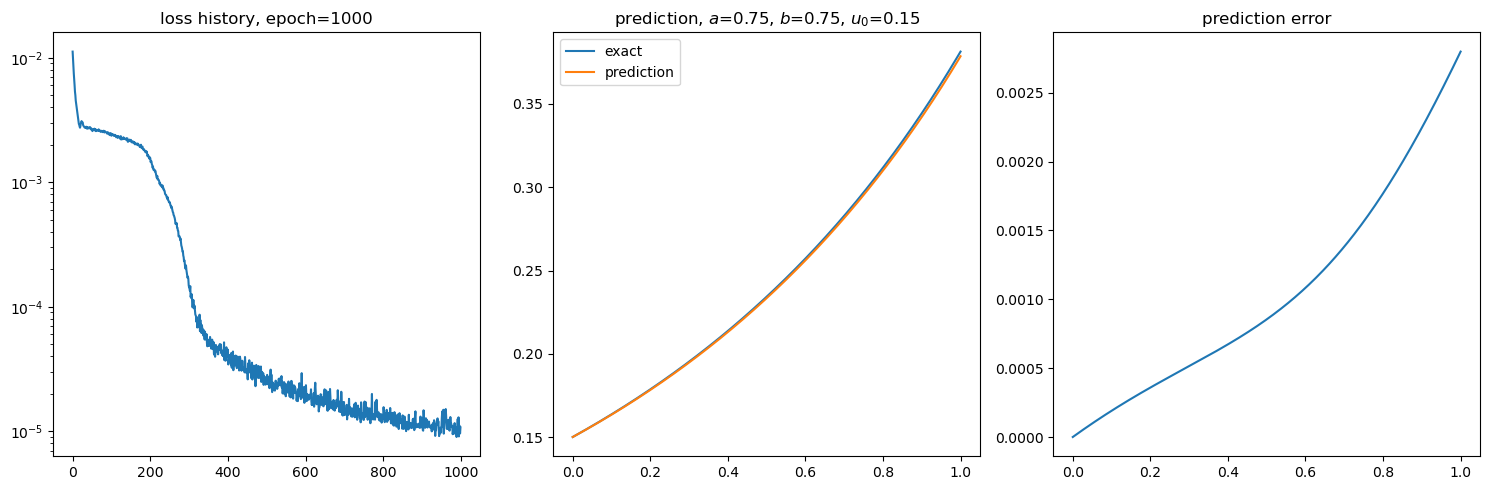

In [6]:
train = True  # trains the model
# train = False  # uses the trained model (only available after training)

if train:
    # new_training = False  # restarts training with the existing trained model
    new_training = True  # deletes the existing model and start a new training

    if new_training:
        try:
            os.remove(Network.DEFAULT_FILE_NAME)
        except FileNotFoundError:
            pass

    model = Network()

    n_epochs = 1000  # number of epochs
    n_collocation = 10_000  # number of collocation points (for the PDE loss)
    n_data = 0  # number of data points (for the data loss)
    model.train(n_epochs=n_epochs, n_collocation=n_collocation, n_data=n_data)

else:
    model = Network()
    model.plot_result(random=True, n_plots=5)


### 2/ Discontinuous Galerkin basis functions with prior

Once the model has been satisfactorily trained (say, once the value of the loss function is lower than $10^{-5}$), one can add it as a prior to the DG scheme.

                           no_prior,  error =  1.208e-05
                          CPU times:  meshing =  4.13e-03
                          CPU times:   scheme =  1.27e+00
                          CPU times:    total =  1.27e+00

                with_prior_additive,  error =  2.495e-07
                          CPU times:  meshing =  2.72e-02
                          CPU times:   scheme =  1.28e+00
                          CPU times:    total =  1.28e+00



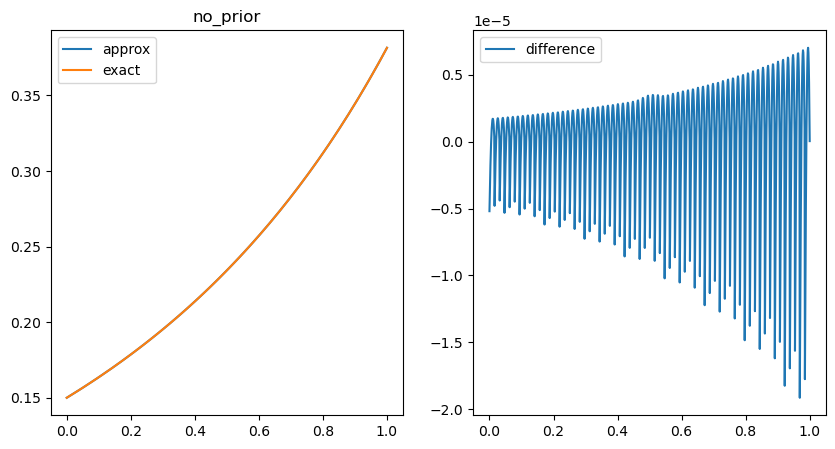

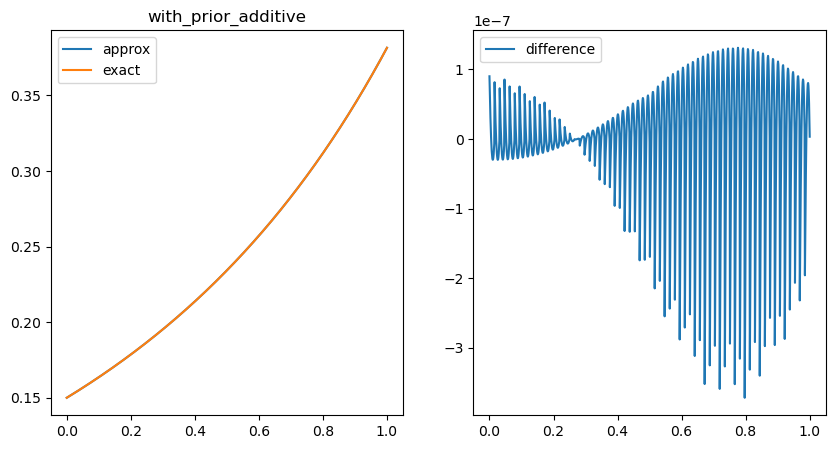

In [29]:
# choose the basis categories you wish to test
categories = [
    "no_prior",
    "with_prior_additive",
    # "with_prior_multiplicative",
]

# perturbed_initial_condition = True  # runs a perturbation analysis
perturbed_initial_condition = False  # check the scheme output

# in both cases, available optional arguments are:
#   nx, integer, the number of space points
#   nG, integer, the number of basis function
#   source, bool, whether to add the source term
#   end_time, float, the final computation time

if perturbed_initial_condition:
    run_perturbation_analysis(categories)
else:
    source = True  # approximation of a steady solution
    # source = False  # pure advection of a Gaussian bump
    end_time = 0.5 if source else 1  # final physical time
    run_and_plot(categories, source=source, end_time=end_time, nx=64, nG=2)
